### XGBoost Credit Risk

Dataset generado de forma aleatoria para efectos educativos.

### Paos

- Verificación Bad rate.
- Definir las categorías y calcular el WOE para una variables independientes.
- Calculo de iv para las variables independientes.
- Modelo XGBoost.
  - Rendimiento del modelo (accuracy).
  - Importancia de las características.
  - 
- Métricas de evaluación.
  - Precision.
  - Recall.
  - F1.
- Validación del modelo.
  - Matriz de confusión.
  - Curva ROC.
  - Curva de presicion-recall.
  - Curva de calibración.
  - Diagrama de importancia de las características.
  - Curva de aprendizaje XGBoots.
  - Visualización de un árbol individual.
- Ajuste de hiperparámetros.
  - Mejores hiperparámetros.
  - Presición de modelo con nuevos hiperparámetros.
- Métricas de performance.
  - ROC
  - KS
  - GINI

In [ ]:
''' 
pip install xgboost scikit-learn
pip install graphviz xgboost
'''

In [1]:
pwd

'/Users/michael/Documents/Python/ProyestosPersonales/Modelos/statistical_models/XGBoots_models/01 - Credit_risk_model/NOTEBOOKS'

In [2]:
# Tratamiento de datos
import numpy as np
import pandas as pd

# Modelo
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import plot_tree
import graphviz

# Métricas de evaluación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Validaciones gráficas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

In [3]:
# Leer el archivo CSV generado en un DataFrame
data = pd.read_csv('/Users/michael/Documents/Python/ProyestosPersonales/Modelos/statistical_models/XGBoots_models/01 - Credit_risk_model/DATA/dataset_crediticio.csv',sep=';')
# Transformar los nombres de las columnas a minúsculas
data.columns = [column.lower() for column in data.columns]
data.shape

(10000, 16)

In [4]:
data.head(3)

,id,edad,ingresos_anuales,historial_crediticio,monto_del_prestamo,plazo_del_prestamo,tasa_de_interes,deuda_existente,numero_de_dependientes,estado_laboral,proposito_del_prestamo,estado_civil,nivel_de_educacion,score_de_riesgo_interno,resultado_del_riesgo,periodo
0,1,31,"$78,719.00",Bueno,"$35,098.00",30,11.8%,"$10,438.00",3,Autónomo,Otros,Divorciado,Maestría,507,1,2022-06
1,2,29,"$43,660.00",Regular,"$43,304.00",34,7.4%,"$1,581.00",0,Desempleado,Emergencia,Divorciado,Maestría,804,1,2022-05
2,3,58,"$56,278.00",Malo,"$12,629.00",9,10.9%,"$24,983.00",5,Desempleado,Auto,Soltero,Preparatoria,629,1,2022-04


In [5]:
# Tasa de malos
bad_rate = data['resultado_del_riesgo'].value_counts().reset_index()
bad_rate = bad_rate.rename(columns={'index': 'Categorias', 'resultado_del_riesgo': 'Qtd'})
bad_rate['%'] = round(bad_rate['Qtd'] / bad_rate['Qtd'].sum(), 1) * 100
bad_rate

,Categorias,Qtd,%
0,1,8892,90.0
1,0,1108,10.0


In [6]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       10000 non-null  int64 
 1   edad                     10000 non-null  int64 
 2   ingresos_anuales         10000 non-null  object
 3   historial_crediticio     10000 non-null  object
 4   monto_del_prestamo       10000 non-null  object
 5   plazo_del_prestamo       10000 non-null  int64 
 6   tasa_de_interes          10000 non-null  object
 7   deuda_existente          10000 non-null  object
 8   numero_de_dependientes   10000 non-null  int64 
 9   estado_laboral           10000 non-null  object
 10  proposito_del_prestamo   10000 non-null  object
 11  estado_civil             10000 non-null  object
 12  nivel_de_educacion       10000 non-null  object
 13  score_de_riesgo_interno  10000 non-null  int64 
 14  resultado_del_riesgo     10000 non-null

### Transformación en WoEs

In [7]:
# Definir las categorías y calcular el WOE para una variables independientes
def calcular_woe_variable(variable, target):
    tabla_frecuencia = data.groupby([variable, target]).size().unstack()
    total_buenos = tabla_frecuencia[1].sum()
    total_malos = tabla_frecuencia[0].sum()

    woe = {}
    iv = 0

    for categoria in tabla_frecuencia.index:
        evento_malo = tabla_frecuencia.loc[categoria, 0]
        evento_bueno = tabla_frecuencia.loc[categoria, 1]

        woe[categoria] = round((evento_malo / total_malos) / (evento_bueno / total_buenos), 2)
        iv += ((evento_malo / total_malos) - (evento_bueno / total_buenos)) * woe[categoria]

    return woe

# Lista de variables independientes para transformar
variables_independientes = ['edad','historial_crediticio','plazo_del_prestamo','tasa_de_interes',
'numero_de_dependientes','estado_laboral','proposito_del_prestamo','estado_civil','nivel_de_educacion'] #,'score_de_riesgo_interno','monto_del_prestamo','ingresos_anuales','deuda_existente'

# Transformar las variables independientes en WOE
for variable in variables_independientes:
    woe_dict = calcular_woe_variable(variable, 'resultado_del_riesgo')
    data[variable + '_WOE'] = data[variable].map(woe_dict)

In [8]:
data.head(3)

,id,edad,ingresos_anuales,historial_crediticio,monto_del_prestamo,plazo_del_prestamo,tasa_de_interes,deuda_existente,numero_de_dependientes,estado_laboral,...,periodo,edad_WOE,historial_crediticio_WOE,plazo_del_prestamo_WOE,tasa_de_interes_WOE,numero_de_dependientes_WOE,estado_laboral_WOE,proposito_del_prestamo_WOE,estado_civil_WOE,nivel_de_educacion_WOE
0,1,31,"$78,719.00",Bueno,"$35,098.00",30,11.8%,"$10,438.00",3,Autónomo,...,2022-06,1.01,1.00,0.78,0.84,0.89,1.0,0.90,0.96,1.03
1,2,29,"$43,660.00",Regular,"$43,304.00",34,7.4%,"$1,581.00",0,Desempleado,...,2022-05,0.76,0.97,1.08,1.40,0.94,1.0,0.94,0.96,1.03
2,3,58,"$56,278.00",Malo,"$12,629.00",9,10.9%,"$24,983.00",5,Desempleado,...,2022-04,0.89,1.03,0.97,0.59,1.02,1.0,1.04,1.04,0.99


### Calculo de iv

In [9]:
tabla_frecuencia = data.groupby([variable, 'resultado_del_riesgo']).size().unstack()
total_buenos = tabla_frecuencia[1].sum()
total_malos = tabla_frecuencia[0].sum()
# Crear una lista para almacenar los valores de IV por variable
iv_summary = []

# Calcular y mostrar el WOE y el IV para cada variable
for variable in variables_independientes:
    woe_dict = calcular_woe_variable(variable, 'resultado_del_riesgo')
    data[variable + '_WOE'] = data[variable].map(woe_dict)

    iv = 0
    for categoria, woe in woe_dict.items():
        evento_malo = data[data[variable] == categoria]['resultado_del_riesgo'].sum()
        evento_bueno = data[data[variable] == categoria]['resultado_del_riesgo'].count() - evento_malo

        iv += ((evento_malo / total_malos) - (evento_bueno / total_buenos)) * woe

    iv_summary.append({'Variable': variable, 'IV': iv})

# Crear un DataFrame para mostrar la tabla resumen de IV
iv_df = pd.DataFrame(iv_summary)

# Ordenar el DataFrame por IV en orden descendente
iv_df = iv_df.sort_values(by='IV', ascending=False)

# Mostrar la tabla resumen de IV
iv_df

,Variable,IV
5,estado_laboral,7.926616
6,proposito_del_prestamo,7.904271
4,numero_de_dependientes,7.902440
8,nivel_de_educacion,7.899854
2,plazo_del_prestamo,7.899711
7,estado_civil,7.898386
1,historial_crediticio,7.897124
0,edad,7.889817
3,tasa_de_interes,7.886394


In [10]:
# Filtrar las columnas que terminan con "_woe" más el target
data = data.filter(regex='_WOE$|resultado_del_riesgo')
data.head(3)

,resultado_del_riesgo,edad_WOE,historial_crediticio_WOE,plazo_del_prestamo_WOE,tasa_de_interes_WOE,numero_de_dependientes_WOE,estado_laboral_WOE,proposito_del_prestamo_WOE,estado_civil_WOE,nivel_de_educacion_WOE
0,1,1.01,1.00,0.78,0.84,0.89,1.0,0.90,0.96,1.03
1,1,0.76,0.97,1.08,1.40,0.94,1.0,0.94,0.96,1.03
2,1,0.89,1.03,0.97,0.59,1.02,1.0,1.04,1.04,0.99


In [11]:
def get_na(df):
    qsna = df.shape[0] - df.isnull().sum(axis = 0) #Cantidad de NA
    qna = df.isnull().sum(axis = 0)
    ppna = round(100*(qna/df.shape[0]),2)
    aux = {'Datos sin Nas en qtd': qsna, 'Na en qtd': qna, 'Na en %': ppna}
    na = pd.DataFrame(data = aux)
    return na.sort_values(by = 'Na en qtd', ascending = False)

In [12]:
get_na(data)

,Datos sin Nas en qtd,Na en qtd,Na en %
resultado_del_riesgo,10000,0,0.0
edad_WOE,10000,0,0.0
historial_crediticio_WOE,10000,0,0.0
plazo_del_prestamo_WOE,10000,0,0.0
tasa_de_interes_WOE,10000,0,0.0
numero_de_dependientes_WOE,10000,0,0.0
estado_laboral_WOE,10000,0,0.0
proposito_del_prestamo_WOE,10000,0,0.0
estado_civil_WOE,10000,0,0.0
nivel_de_educacion_WOE,10000,0,0.0


In [13]:
# Guardar el conjunto de datos transformado en un nuevo archivo parquet
data.to_parquet('/Users/michael/Documents/Python/ProyestosPersonales/Modelos/statistical_models/XGBoots_models/01 - Credit_risk_model/DATA/dataset_crediticio_woe.parquet', index=False)

### Modelo XGboots

In [14]:
# Definir características y objetivo
features = data.drop(['resultado_del_riesgo'], axis=1)
target = data['resultado_del_riesgo']

In [15]:
# Dividimos el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Creamos un objeto DMatrix para XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definimos los hiperparámetros del modelo
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'mlogloss'
}

# Entrenamos el modelo
num_round = 100
model = xgb.train(params, dtrain, num_round)

# Realizamos predicciones en el conjunto de prueba
y_pred = model.predict(dtest)

# Evaluamos el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy:.2f}')

Precisión del modelo: 0.89


In [16]:
# Obtener importancia de las características
feature_importances = model.get_score(importance_type='weight')
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Imprimir la importancia de las características
print("Importancia de las características:")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

Importancia de las características:
tasa_de_interes_WOE: 348.0
edad_WOE: 286.0
plazo_del_prestamo_WOE: 234.0
proposito_del_prestamo_WOE: 150.0
numero_de_dependientes_WOE: 124.0
nivel_de_educacion_WOE: 80.0
estado_civil_WOE: 55.0
historial_crediticio_WOE: 48.0
estado_laboral_WOE: 30.0


### Métricas de evaluación

- Precision.
- Recall.
- F1.

In [17]:
# Calculamos las métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Imprimimos las métricas
print(f'Precisión: {accuracy:.2f}')
print(f'Recuperación: {recall:.2f}')
print(f'Puntuación F1: {f1:.2f}')

Precisión: 0.89
Recuperación: 0.89
Puntuación F1: 0.84


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Interpretación de las métricas

### Validación del modelo

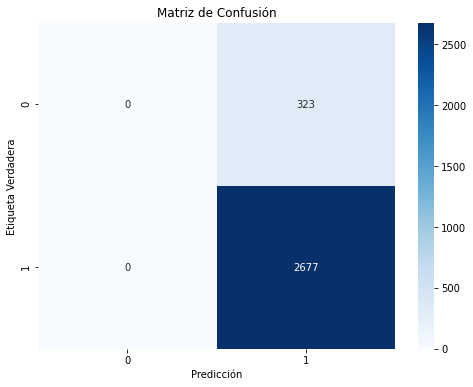

In [18]:
# Calculamos la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizamos la matriz de confusión usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

### Curva ROC

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


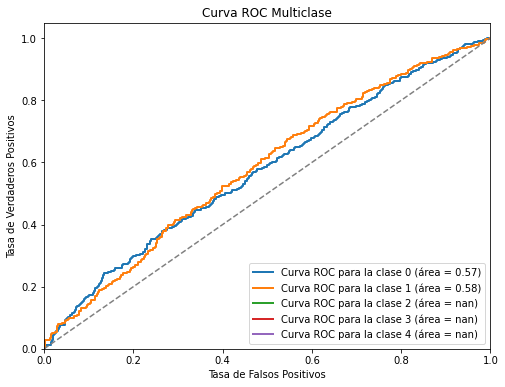

In [19]:
from sklearn.preprocessing import label_binarize
# Realizar predicciones de probabilidades en el conjunto de prueba
y_prob = model.predict(dtest, output_margin=True)  # Usar output_margin=True para obtener probabilidades

# Binarizar las etiquetas para el cálculo de la curva ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

# Calcular la curva ROC y el área bajo la curva para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(params['num_class']):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar la curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in range(params['num_class']):
    plt.plot(fpr[i], tpr[i], lw=2, label='Curva ROC para la clase {0} (área = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Multiclase')
plt.legend(loc="lower right")
plt.show()

### Curva de presicion-recall

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No posit

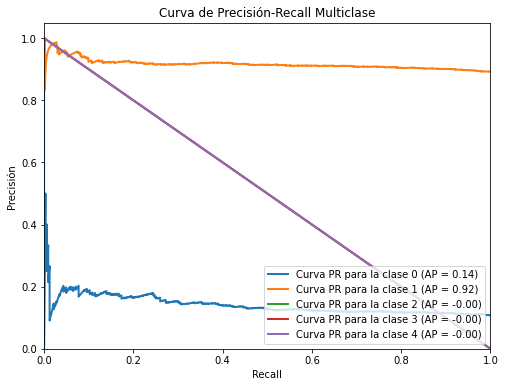

In [20]:
# Binarizar las etiquetas para el cálculo de la curva PR
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

# Calcular la curva PR y el área bajo la curva para cada clase
precision = dict()
recall = dict()
average_precision = dict()

for i in range(params['num_class']):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_prob[:, i])

# Graficar la curva PR para cada clase
plt.figure(figsize=(8, 6))
for i in range(params['num_class']):
    plt.plot(recall[i], precision[i], lw=2, label='Curva PR para la clase {0} (AP = {1:.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva de Precisión-Recall Multiclase')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

La Curva PR muestra cómo varía la precisión en función de la recuperación a medida que cambia el umbral de decisión del modelo. El área bajo la curva (AP, Average Precision) proporciona una medida cuantitativa de la calidad del modelo en términos de precisión y recuperación. Cuanto mayor sea el valor de AP, mejor será el rendimiento del modelo en términos generales.

### Curva de calibración

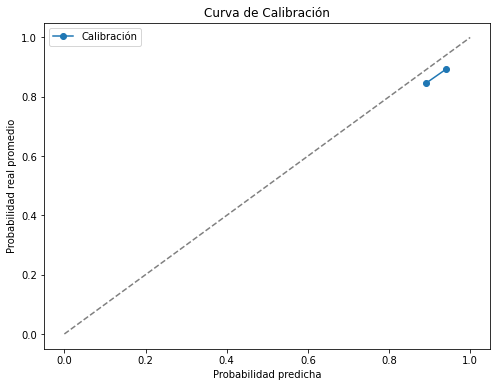

In [21]:
# Realizar predicciones de margen en el conjunto de prueba
margins = model.predict(dtest, output_margin=True)

# Convertir los márgenes en probabilidades utilizando la función sigmoide
y_prob = 1 / (1 + np.exp(-margins))

# Calcular la curva de calibración
prob_true, prob_pred = calibration_curve(y_test, y_prob[:, 1], n_bins=10)

# Graficar la curva de calibración
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibración')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Probabilidad predicha')
plt.ylabel('Probabilidad real promedio')
plt.title('Curva de Calibración')
plt.legend(loc="upper left")
plt.show()

El gráfico de calibración compara las probabilidades pronosticadas por el modelo con la proporción real de muestras positivas. Una curva de calibración ideal se acercaría a la línea de calibración perfecta (línea diagonal). Un modelo bien calibrado tendría puntos que se ajusten cerca de esta línea.

### Diagrama de importancia de las características.

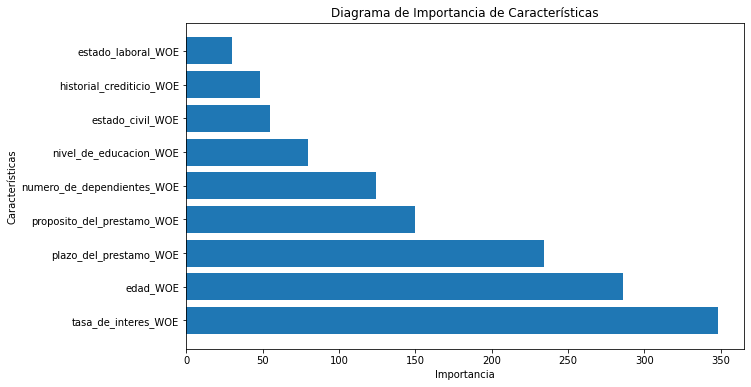

In [22]:
# Diagrama de Importancia de Características:
# Preparar datos para visualización
features, importance = zip(*sorted_feature_importances)
features = list(features)
importance = list(importance)

# Visualizamos el diagrama de importancia de características
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importance, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Diagrama de Importancia de Características')
plt.show()

El diagrama de importancia de características muestra la contribución relativa de cada característica en las predicciones del modelo. Las características con valores de importancia más altos son las que más influyen en las decisiones del modelo. Puedes usar esta visualización para identificar las características más relevantes y tomar decisiones informadas sobre la selección de características o para entender mejor cómo el modelo está tomando decisiones.

### Curva de aprendizaje XGBoots

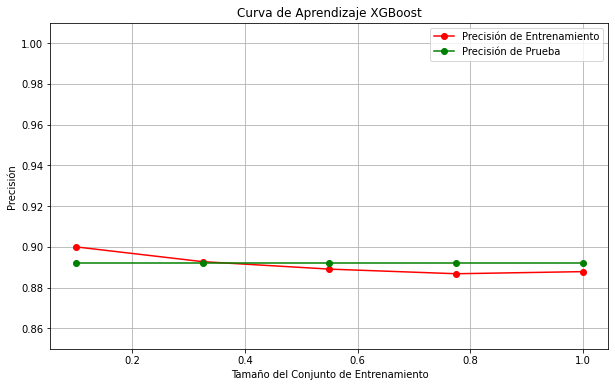

In [23]:
# Función para calcular el rendimiento del modelo en diferentes tamaños de entrenamiento
def plot_learning_curve(estimator, X_train, y_train, X_test, y_test, title, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_scores = []
    test_scores = []
    for train_size in train_sizes:
        subset_size = int(train_size * len(X_train))
        X_subset = X_train[:subset_size]
        y_subset = y_train[:subset_size]

        dtrain = xgb.DMatrix(X_subset, label=y_subset)
        model = xgb.train(params, dtrain)
        
        y_train_pred = model.predict(xgb.DMatrix(X_subset))
        y_test_pred = model.predict(xgb.DMatrix(X_test))
        
        train_scores.append(np.mean(y_subset == (y_train_pred > 0.5)))
        test_scores.append(np.mean(y_test == (y_test_pred > 0.5)))

    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Tamaño del Conjunto de Entrenamiento")
    plt.ylabel("Precisión")
    plt.grid()

    plt.plot(train_sizes, train_scores, 'o-', color="r", label="Precisión de Entrenamiento")
    plt.plot(train_sizes, test_scores, 'o-', color="g", label="Precisión de Prueba")

    plt.legend(loc="best")
    return plt

# Visualizamos la Curva de Aprendizaje
plot_learning_curve(model, X_train, y_train, X_test, y_test, "Curva de Aprendizaje XGBoost", ylim=(0.85, 1.01))
plt.show()

En este código, creamos un ciclo para iterar a través de diferentes tamaños de conjunto de entrenamiento, entrenamos el modelo XGBoost en cada tamaño y calculamos la precisión en el conjunto de entrenamiento y prueba. Luego, utilizamos matplotlib para visualizar la Curva de Aprendizaje. Recuerda que en esta implementación estamos calculando la precisión, pero puedes ajustar el código para calcular y visualizar otras métricas de rendimiento según tus necesidades.

### Visualización de un árbol individual.

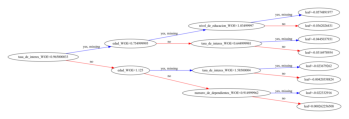

In [24]:
# Visualizamos un árbol individual
plot_tree(model, num_trees=5, rankdir='LR')
plt.show()

### Ajuste de hiperparámetros

#### Mejores hiperparámetros

In [25]:
from xgboost import XGBClassifier
# Definir el modelo XGBoost
model = XGBClassifier()

# Definir los hiperparámetros a ajustar y sus posibles valores
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Realizar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3)
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y su puntaje
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Entrenar el modelo con los mejores hiperparámetros
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular el AUC-ROC en el conjunto de prueba
auc_roc = roc_auc_score(y_test, y_pred)

print("Mejores hiperparámetros:", best_params)
print("Puntaje AUC-ROC en validación cruzada:", best_score)
print("AUC-ROC en conjunto de prueba:", auc_roc)


Mejores hiperparámetros: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Puntaje AUC-ROC en validación cruzada: 0.5999491093347632
AUC-ROC en conjunto de prueba: 0.5


#### Presición de modelo con nuevos hiperparámetros.

In [26]:
# Definir los mejores hiperparámetros que obtuviste de la búsqueda en cuadrícula
best_params = {
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 200,
    # Otros hiperparámetros aquí...
}

# Crear y entrenar el modelo XGBoost con los nuevos hiperparámetros
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)

# Predecir etiquetas en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la precisión del modelo en el conjunto de prueba
accuracy_new = accuracy_score(y_test, y_pred)
print("Precisión del modelo con nuevos hiperparámetros:", accuracy)

Precisión del modelo con nuevos hiperparámetros: 0.8923333333333333


In [27]:
print(round(accuracy,4))
print(round(accuracy_new,4))

0.8923
0.8923


### Medidas de performance

In [28]:
# Definir características y objetivo
features = data.drop(['resultado_del_riesgo'], axis=1)
target = data['resultado_del_riesgo']

In [29]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy import stats
import numpy as np

# Dividimos el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Creamos un objeto DMatrix para XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definimos los hiperparámetros del modelo
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'mlogloss'
}

# Entrenamos el modelo
num_round = 100
model = xgb.train(params, dtrain, num_round)

# Realizamos predicciones de probabilidades en el conjunto de prueba
y_prob = model.predict(dtest, output_margin=True)  # Usar output_margin=True para obtener márgenes

# Convertir márgenes en probabilidades utilizando la función sigmoide
y_prob = 1 / (1 + np.exp(-y_prob))

# Calcular las métricas KS, ROC AUC y GINI
ks_values = []
roc_auc_values = []

for i in range(params['num_class']):
    y_true_class = (y_test == i).astype(int)
    if np.sum(y_true_class == 1) > 0 and np.sum(y_true_class == 0) > 0:
        ks_statistic, _ = stats.ks_2samp(y_prob[:, i][y_true_class == 1], y_prob[:, i][y_true_class == 0])
        ks_values.append(ks_statistic)
        
        roc_auc = roc_auc_score(y_true_class, y_prob[:, i])
        roc_auc_values.append(roc_auc)

max_ks = max(ks_values)
avg_roc_auc = sum(roc_auc_values) / len(roc_auc_values)
gini = 2 * avg_roc_auc - 1

# Mostrar las métricas
print(f"KS Máximo: {max_ks:.4f}")
print(f"Área bajo la curva ROC (ROC AUC): {avg_roc_auc:.4f}")
print(f"Índice de GINI: {gini:.4f}")

# Evaluamos el rendimiento del modelo
y_pred = model.predict(dtest)
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy:.2f}')


KS Máximo: 0.1304
Área bajo la curva ROC (ROC AUC): 0.5784
Índice de GINI: 0.1568
Precisión del modelo: 0.89
